# Create Baseline model for our predictor


### Load Data

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import random

In [42]:

# ------- Config --------

FOLDER = "Datos"          # Carpeta con CSVs
REPORT = "profile.html"   # Salida del reporte
SAMPLE = None             # e.g., 20000 para muestrear filas si es muy grande

# 1) Cargar y unir CSVs
files = [f for f in os.listdir(FOLDER) if f.lower().endswith(".csv")]
if not files:
    raise FileNotFoundError(f"No hay CSVs en '{FOLDER}'")

dfs = []
for f in files:
    path = os.path.join(FOLDER, f)
    # dtype=object evita inferencias agresivas; luego convertimos
    df_part = pd.read_csv(path, dtype=object, low_memory=False)
    df_part["__archivo_origen"] = f
    dfs.append(df_part)

df = pd.concat(dfs, ignore_index=True)

In [43]:
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,__archivo_origen
0,2024-0339,Brisbane,Hard,32,A,20240101,300,105777,2,NaN,...,44,16,11,8,9,14,2570,8,3660,atp_matches_2024.csv
1,2024-0339,Brisbane,Hard,32,A,20240101,299,208029,1,NaN,...,31,10,11,5,7,8,3660,39,1122,atp_matches_2024.csv
2,2024-0339,Brisbane,Hard,32,A,20240101,298,105777,2,NaN,...,24,14,10,5,7,14,2570,55,902,atp_matches_2024.csv
3,2024-0339,Brisbane,Hard,32,A,20240101,297,208029,1,NaN,...,31,16,10,3,5,8,3660,116,573,atp_matches_2024.csv
4,2024-0339,Brisbane,Hard,32,A,20240101,296,126128,NaN,NaN,...,27,16,10,5,8,39,1122,44,1021,atp_matches_2024.csv


In [44]:
# Tamaño del dataset y columnas
print(df.shape)
print(df.columns)


(13174, 50)
Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points',
       '__archivo_origen'],
      dtype='object')


In [45]:
# --- BLOQUE 2: Limpieza básica y filtrado de columnas ---

# Eliminar columnas de texto que no aportan al modelo base
drop_cols = [
    'tourney_id','tourney_name','winner_entry','loser_entry',
    '__archivo_origen','tourney_date','match_num'
]
#eliminamos el tourney date para que no influya en el modelo

df = df.drop(columns=drop_cols, errors='ignore')

# Convertir todo lo posible a numérico
df = df.apply(pd.to_numeric, errors='ignore')

# Eliminar filas con NaN en variables críticas
df = df.dropna(subset=['winner_rank', 'loser_rank'])

# Crear variable binaria objetivo (1 = ganó jugador 1)
df['target'] = 1  # En tu df el "winner" siempre está identificado, luego cambiaremos


/var/folders/5x/v_n3jdfd003f7mqj3m9j1k0h0000gn/T/ipykernel_94116/1728113200.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


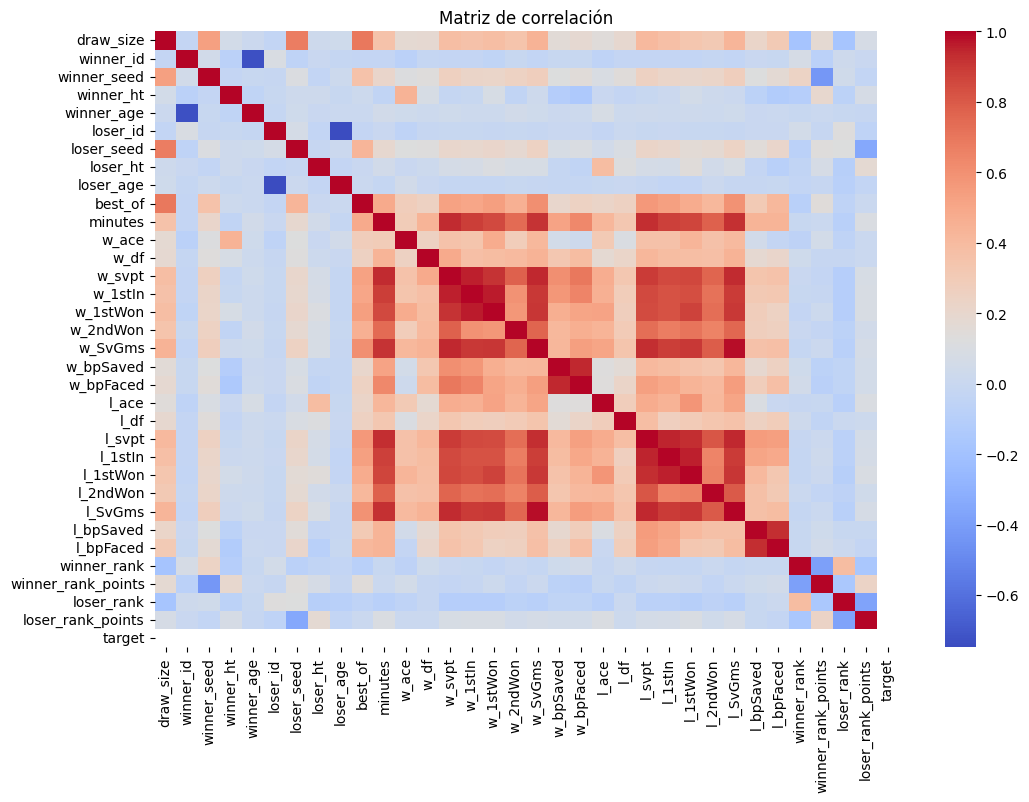

[('minutes', 'w_svpt'),
 ('minutes', 'w_SvGms'),
 ('minutes', 'l_svpt'),
 ('minutes', 'l_SvGms'),
 ('w_svpt', 'minutes'),
 ('w_svpt', 'w_1stIn'),
 ('w_svpt', 'w_1stWon'),
 ('w_svpt', 'w_SvGms'),
 ('w_svpt', 'l_SvGms'),
 ('w_1stIn', 'w_svpt'),
 ('w_1stIn', 'w_1stWon'),
 ('w_1stIn', 'w_SvGms'),
 ('w_1stWon', 'w_svpt'),
 ('w_1stWon', 'w_1stIn'),
 ('w_1stWon', 'w_SvGms'),
 ('w_SvGms', 'minutes'),
 ('w_SvGms', 'w_svpt'),
 ('w_SvGms', 'w_1stIn'),
 ('w_SvGms', 'w_1stWon'),
 ('w_SvGms', 'l_svpt'),
 ('w_SvGms', 'l_1stWon'),
 ('w_SvGms', 'l_SvGms'),
 ('w_bpSaved', 'w_bpFaced'),
 ('w_bpFaced', 'w_bpSaved'),
 ('l_svpt', 'minutes'),
 ('l_svpt', 'w_SvGms'),
 ('l_svpt', 'l_1stIn'),
 ('l_svpt', 'l_1stWon'),
 ('l_svpt', 'l_SvGms'),
 ('l_1stIn', 'l_svpt'),
 ('l_1stIn', 'l_1stWon'),
 ('l_1stWon', 'w_SvGms'),
 ('l_1stWon', 'l_svpt'),
 ('l_1stWon', 'l_1stIn'),
 ('l_1stWon', 'l_SvGms'),
 ('l_SvGms', 'minutes'),
 ('l_SvGms', 'w_svpt'),
 ('l_SvGms', 'w_SvGms'),
 ('l_SvGms', 'l_svpt'),
 ('l_SvGms', 'l_1stWon')

In [46]:
# --- BLOQUE 3: Análisis de colinealidad ---

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Matriz de correlación")
plt.show()

# Calcular pares de alta correlación (>0.9)
high_corr = [(c1, c2) for c1 in corr.columns for c2 in corr.columns
              if c1 != c2 and abs(corr.loc[c1, c2]) > 0.9]
high_corr


Eliminamos las que tienen correlación muy alta entre sí, pues podemos tener probelmas de colinealidad

In [47]:

# Elige solo numéricas
num_cols = df.select_dtypes(include=[np.number]).columns

# Matriz de correlación
corr = df[num_cols].corr().abs()

# Umbral de colinealidad (ajústalo si hace falta)
THRESH = 0.9

# Máscara de la mitad superior (excluye diagonal)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Columnas a dropear: si alguna correlación > THRESH en la fila de esa col, la marcamos
to_drop = [column for column in upper.columns if any(upper[column] > THRESH)]

print(f"Propuestas para dropear por colinealidad (>{THRESH}): {to_drop}")


Propuestas para dropear por colinealidad (>0.9): ['w_svpt', 'w_1stIn', 'w_1stWon', 'w_SvGms', 'w_bpFaced', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_SvGms', 'l_bpFaced']


In [48]:
df.columns

Index(['surface', 'draw_size', 'tourney_level', 'winner_id', 'winner_seed',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_name', 'loser_hand', 'loser_ht',
       'loser_ioc', 'loser_age', 'score', 'best_of', 'round', 'minutes',
       'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
       'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn',
       'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'target'],
      dtype='object')

Hacemos un ánalisis de colinealidad: 

-vars: 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_SvGms', 'w_bpFaced', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_SvGms', 'l_bpFaced'


- 'w_svpt': “winner serve points” — número total de puntos de servicio que jugó el ganador

- 'w_1stIn': “winner first serves in” — cuántos primeros saques del ganador entraron

- 'w_1stWon':“winner first serve points won” — cuántos puntos ganó el ganador cuando su primer saque fue exitoso

- 'w_SvGms':“winner service games” — número de juegos de servicio que ganó el ganador

- 'w_bpFaced': “winner break points faced” — cuántas oportunidades de quiebre enfrentó el ganador

- 'l_svpt': igual que w_svpt, pero para el jugador perdedor

- 'l_1stIn': igual que w_1stIn, pero para el perdedor

- 'l_1stWon': “loser first serve points won”

- 'l_SvGms': “loser service games”

- 'l_bpFaced': “loser break points faced”


Podemos ver la dependecia lineal

'w_1stWon' = 'w_svpt'+ 'w_1stIn': El número total de puntos servidos (w_svpt) ≈ número de primeros saques (w_1stIn) + segundos saques. Si además tienes w_1stWon, una de ellas será redundante.

'l_1stWon' = 'l_svpt'+ 'l_1stIn': Lo mismo pero para el perdedor

'w_SvGms' = 'l_SvGms' (igual o menos 1): En un partido ATP, el total de juegos es casi constante: si el ganador jugó 12 juegos de servicio, el perdedor también jugó 12 o uno menos. Muy correlacionadas.


'w_bpFaced' muy correlacionado con 'l_bpFaced': Cuantos más break points enfrenta uno, menos enfrenta el otro. Altamente correlacionadas (negativamente).


In [49]:
cols_to_drop = ['w_svpt', 'w_1stWon', 'w_SvGms', 'w_bpFaced', 'l_svpt', 'l_1stWon']

Quitamos columnas que se explican linealmente con otras

In [50]:

# Dropea solo las que existan (por seguridad)
cols_present = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=cols_present)

print(f"Se dropearon {len(cols_present)} columnas.")

Se dropearon 6 columnas.


In [51]:
df.columns

Index(['surface', 'draw_size', 'tourney_level', 'winner_id', 'winner_seed',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_name', 'loser_hand', 'loser_ht',
       'loser_ioc', 'loser_age', 'score', 'best_of', 'round', 'minutes',
       'w_ace', 'w_df', 'w_1stIn', 'w_2ndWon', 'w_bpSaved', 'l_ace', 'l_df',
       'l_1stIn', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'target'],
      dtype='object')

## Red básica

Revisón de NaNs

In [52]:
import numpy as np
import pandas as pd

# 1) ¿Cuántos NaNs por columna?
na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts.head(20))

# 2) Si creaste razones/diferencias, revisa si produjiste inf/-inf (divisiones entre 0)
cols_num = df.select_dtypes(include=[np.number]).columns
mask_inf = np.isinf(df[cols_num]).any()
print("Columnas con inf/-inf:", list(cols_num[mask_inf]))

# 3) Convierte inf/-inf a NaN para que el imputador pueda actuar
df[cols_num] = df[cols_num].replace([np.inf, -np.inf], np.nan)

# 4) Verifica que el target no tenga NaN
print("NaNs en target:", df['target'].isna().sum())


loser_seed            9739
winner_seed           7490
minutes                792
w_df                   468
w_1stIn                468
w_2ndWon               468
w_bpSaved              468
l_ace                  468
l_df                   468
l_1stIn                468
l_2ndWon               468
w_ace                  468
l_SvGms                468
l_bpSaved              468
l_bpFaced              468
loser_ht                48
surface                 36
winner_ht               22
winner_rank              0
winner_rank_points       0
dtype: int64

Columnas con inf/-inf: []
NaNs en target: 0


In [53]:
# ============================
# 1) Drop de FILAS con NaN en categóricas (NO se borran columnas)
# ============================
# Identifica categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
before = len(df)
df = df.dropna(subset=cat_cols).copy()
print(f"Filas dropeadas por NaN en categóricas: {before - len(df)}")
print(f"Total filas tras drop: {len(df)}")

# (Opcional) Asegura que no queden inf/-inf en numéricas; se convertirán a NaN y se imputarán
num_cols_all = df.select_dtypes(include=[np.number]).columns
df[num_cols_all] = df[num_cols_all].replace([np.inf, -np.inf], np.nan)


Filas dropeadas por NaN en categóricas: 36
Total filas tras drop: 12950


Imputar

In [54]:

num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != 'target']
df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)

# Media por columna (Series: col -> media)
col_means = df[num_cols].mean()

# Imputa NaN de cada columna con SU propia media
df[num_cols] = df[num_cols].fillna(col_means)

# (Opcional) ver qué media usaste por columna
print(col_means.to_string())

draw_size                 62.367104
winner_id             139526.278147
winner_seed                7.806405
winner_ht                187.728869
winner_age                26.679174
loser_id              137770.293127
loser_seed                 9.299969
loser_ht                 186.616225
loser_age                 27.126579
best_of                    3.378224
minutes                  116.460062
w_ace                      7.061591
w_df                       2.544576
w_1stIn                   50.260185
w_2ndWon                  16.081083
w_bpSaved                  3.484263
l_ace                      5.330404
l_df                       3.179422
l_1stIn                   50.862039
l_2ndWon                  14.590430
l_SvGms                   12.511184
l_bpSaved                  4.805081
l_bpFaced                  8.526761
winner_rank               69.277915
winner_rank_points      1931.540541
loser_rank               104.228803
loser_rank_points       1217.554749


In [60]:
df.head()

,surface,draw_size,tourney_level,winner_id,winner_seed,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,...,l_1stIn,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,target
0,Hard,32,A,105777,2.000000,Grigor Dimitrov,R,191.0,BUL,32.6,...,58.0,16.0,11.0,8.0,9.0,14.0,2570.0,8.0,3660.0,1
1,Hard,32,A,208029,1.000000,Holger Rune,R,188.0,DEN,20.6,...,35.0,10.0,11.0,5.0,7.0,8.0,3660.0,39.0,1122.0,1
2,Hard,32,A,105777,2.000000,Grigor Dimitrov,R,191.0,BUL,32.6,...,39.0,14.0,10.0,5.0,7.0,14.0,2570.0,55.0,902.0,1
3,Hard,32,A,208029,1.000000,Holger Rune,R,188.0,DEN,20.6,...,51.0,16.0,10.0,3.0,5.0,8.0,3660.0,116.0,573.0,1
4,Hard,32,A,126128,7.806405,Roman Safiullin,R,185.0,RUS,26.4,...,37.0,16.0,10.0,5.0,8.0,39.0,1122.0,44.0,1021.0,1


# Ficha técnica del modelo (ATP Match Winner – NN)

## Objetivo
Predecir la probabilidad de victoria entre dos jugadores (A vs B) en un partido ATP. La red devuelve P(A gana) y P(B gana).

## Construcción del dataset (pairing A vs B)

- **Emparejado simétrico**: cada partido se duplica en dos filas:
  - Fila positiva: A = winner, B = loser, `y = 1`.
  - Fila negativa: A = loser, B = winner, `y = 0`.
- **Features diferenciales (A − B)** para evitar colinealidad y asegurar simetría:
  - Pre-match: `diff_rank`, `diff_rank_points`, `diff_seed`, `diff_ht`, `diff_age`.
  - (Opcional, desactivado para evitar fuga): estadísticas in-match como `diff_1stIn`, `diff_1stWon`, `diff_bpFaced`, etc.
- **Categóricas de contexto** (no se restan): `surface`, `tourney_level`.
- (Opcional) **indicadores binarios** entre jugadores: `same_hand`, `same_ioc`.

**Motivación del pairing**: garantiza ambas clases (0/1), mantiene el problema simétrico (intercambiar A↔B invierte la etiqueta) y simplifica la interpretación de coeficientes y pesos.

## Preprocesamiento

- Numéricas → `StandardScaler` (media 0, var 1).
- Categóricas → `OneHotEncoder(handle_unknown="ignore")`.
- Transformación hecha con `ColumnTransformer`, ajustada solo en train y aplicada a val/test.
- **Supuesto**: el `df` ya no contiene NaNs (si aparecieran, numéricas → media; categóricas → drop de filas con NaN).

## Arquitectura de la red (Keras, `Sequential`)

- **Entrada**: vector denso resultante del preprocesamiento.
- **Capa 1**: `Dense(128, activation='relu')`
- **Dropout**: `0.30`
- **Capa 2**: `Dense(64, activation='relu')`
- **Dropout**: `0.20`
- **Salida**: `Dense(2, activation='softmax')` → prob. por clase `[P(B), P(A)]`.
- **Regularización L2**: ligera (`kernel_regularizer=l2(1e-6)`) en capas densas.

### Justificación del diseño

- 128→64 neuronas: capacidad suficiente para relaciones no lineales en datos tabulares con decenas-centenas de features (tras one-hot), evitando sobreparametrización.
- ReLU por convergencia estable/rápida en tabular.
- Dropout + L2 para controlar sobreajuste (especialmente útil con features derivadas y one-hot).
- Softmax (2) para probabilidades bien calibradas por clase.

## Función de pérdida, optimizador y batching

- **Loss**: `sparse_categorical_crossentropy` (clases {0,1} sin one-hot).
- **Optimizador**: `Adam(learning_rate=1e-3)`.
- **Esquema de descenso**: mini-batch gradient descent con `batch_size=256`. (No es full batch; mini-batch ofrece mejor estabilidad/velocidad práctica.)

## Entrenamiento y callbacks

- **División**: 70% train, 15% val, 15% test (via train/val/test splits).
- **EarlyStopping**: `monitor='val_loss'`, `patience=10`, `restore_best_weights=True`.
- **ReduceLROnPlateau**: reduce LR (×0.5) al estancarse `val_loss` (patience=4).
- **Épocas**: hasta 100 (corta antes con EarlyStopping).
- **Seed**: 42 para reproducibilidad (Python/NumPy/TF).

## Métricas y gráficos

- **Métricas principales**: `accuracy` durante entrenamiento; en evaluación adicional: ROC-AUC, log loss y matriz de clasificación binaria vía scikit-learn.
- **Gráficas**:
  - Loss (train vs val) por época y línea horizontal con test loss final.
  - Error (1−accuracy) para train/val y valor final de test.
- **Interpretación típica** (ejemplo de tu corrida): `train/val loss` decrecientes y cercanas, con test loss en línea con `val loss` → modelo estable y sin sobreajuste marcado.

## Supuestos y buenas prácticas

- Para predicción previa al partido, usar solo pre-match (como está configurado) para evitar data leakage.
- Si hay desbalance de clases (no debería con pairing), considerar `class_weight='balanced'`.
- Guardar `preprocess` y `model` para inferencia consistente en producción.

## Hiperparámetros clave (fáciles de ajustar)

- `learning_rate` (p. ej., `5e-4` si oscilan las curvas).
- `dropout` (`0.30/0.20` → subir si hay sobreajuste, bajar si underfitting).
- `l2_reg` (`1e-6` → probar `1e-5` o `1e-4` si hace falta más regularización).
- Profundidad/ancho: añadir `Dense(32)` extra si el modelo se queda corto.

In [69]:
# =========================================
# NN para P(A gana) con pairing A vs B (softmax)
# =========================================

# ---- BLOQUE 0: Imports y seed
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, roc_auc_score, log_loss

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# ---- BLOQUE 1: Construir dataset A vs B (solo PRE-MATCH para evitar fuga)
# Definimos bases pre-match que existan en tu df (winner_* y loser_*)
PREMATCH_NUM = ["rank", "rank_points", "seed", "ht", "age"]

def has_pair(df, base):
    return ("winner_"+base in df.columns) and ("loser_"+base in df.columns)

def build_pair_df(df, cat_keep=("surface","tourney_level")):
    # Quedarnos solo con las categóricas que existan
    cat_keep = [c for c in cat_keep if c in df.columns]
    rows_pos, rows_neg = [], []
    bases = [b for b in PREMATCH_NUM if has_pair(df, b)]

    # Flags entre jugadores (opcional)
    has_hands = ("winner_hand" in df.columns) and ("loser_hand" in df.columns)
    has_ioc   = ("winner_ioc"  in df.columns) and ("loser_ioc"  in df.columns)

    for _, r in df.iterrows():
        pos = {}
        # Diferencias A−B (A = winner en la fila positiva)
        for b in bases:
            pos[f"diff_{b}"] = r["winner_"+b] - r["loser_"+b]

        # Categóricas de contexto
        for c in cat_keep:
            pos[c] = r[c]

        # Opcional: igualdad de mano / país (numéricas 0/1, se consideran numéricas)
        if has_hands: pos["same_hand"] = int(r["winner_hand"] == r["loser_hand"])
        if has_ioc:   pos["same_ioc"]  = int(r["winner_ioc"]  == r["loser_ioc"])

        pos["target"] = 1
        rows_pos.append(pos)

        # Fila negativa (A = loser): invierte signos de diff_*
        neg = {}
        for k, v in pos.items():
            if k.startswith("diff_"):
                neg[k] = -v
        for c in cat_keep:
            neg[c] = r[c]
        if has_hands: neg["same_hand"] = pos.get("same_hand", 0)
        if has_ioc:   neg["same_ioc"]  = pos.get("same_ioc",  0)
        neg["target"] = 0
        rows_neg.append(neg)

    return pd.DataFrame(rows_pos + rows_neg)

df_pair = build_pair_df(df)
print("df_pair shape:", df_pair.shape)
display(df_pair.head())

# ---- BLOQUE 2: Separar X / y y columnas por tipo
y = df_pair["target"].astype(int).values
X = df_pair.drop(columns=["target"])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()    # incluye diff_* y same_*
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()  # p. ej. surface, tourney_level

print(f"Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}")

# ---- BLOQUE 3: Split y preprocesamiento (Scaler + OneHot denso)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

# OneHotEncoder con compatibilidad de versión
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn ≥ 1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn < 1.2

transformers = []
if len(num_cols) > 0:
    transformers.append(("num", StandardScaler(), num_cols))
if len(cat_cols) > 0:
    transformers.append(("cat", ohe, cat_cols))

preprocess = ColumnTransformer(transformers=transformers, remainder="drop")

X_train_p = preprocess.fit_transform(X_train)
X_val_p   = preprocess.transform(X_val)
X_test_p  = preprocess.transform(X_test)

input_dim = X_train_p.shape[1]
print("input_dim:", input_dim)

# ---- BLOQUE 4: Definir y compilar el modelo (SOFTMAX 2 clases)
def build_model(input_dim, lr=1e-3, l2_reg=1e-6, d1=0.30, d2=0.20):
    reg = tf.keras.regularizers.l2(l2_reg)
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu", kernel_regularizer=reg),
        layers.Dropout(d1),
        layers.Dense(64, activation="relu",  kernel_regularizer=reg),
        layers.Dropout(d2),
        layers.Dense(2, activation="softmax")
    ])
    m.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]  # AUC lo calculamos con sklearn sobre P(A)
    )
    return m

model = build_model(input_dim=input_dim, lr=1e-3, l2_reg=1e-6, d1=0.30, d2=0.20)
model.summary()

# ---- BLOQUE 5: Entrenamiento con callbacks
es  = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6)

hist = model.fit(
    X_train_p, y_train,
    validation_data=(X_val_p, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[es, rlr],
    verbose=1
)

# ---- BLOQUE 6: Evaluación
probs = model.predict(X_test_p)      # shape (n,2) -> [P(B), P(A)]
pA = probs[:, 1]
y_pred = (pA >= 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("ROC-AUC (A positiva):", roc_auc_score(y_test, pA))
print("LogLoss:", log_loss(y_test, probs))

# Muestra rápida
pd.DataFrame({"y_true": y_test[:10], "P_A": pA[:10].round(3), "pred": y_pred[:10]})


df_pair shape: (25900, 10)


,diff_rank,diff_rank_points,diff_seed,diff_ht,diff_age,surface,tourney_level,same_hand,same_ioc,target
0,6.0,-1090.0,1.000000,3.0,12.0,Hard,A,1,0,1
1,-31.0,2538.0,-8.299969,3.0,-5.8,Hard,A,1,0,1
2,-41.0,1668.0,-7.299969,8.0,2.9,Hard,A,1,0,1
3,-108.0,3087.0,-8.299969,5.0,-11.3,Hard,A,1,0,1
4,-5.0,101.0,-1.493565,0.0,3.6,Hard,A,1,0,1


Numéricas: 7 | Categóricas: 2
input_dim: 16


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,562 (41.26 KB)

 Trainable params: 10,562 (41.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6530 - loss: 0.6263 - val_accuracy: 0.6767 - val_loss: 0.6111 - learning_rate: 0.0010
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6861 - loss: 0.6049 - val_accuracy: 0.7158 - val_loss: 0.5922 - learning_rate: 0.0010
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7178 - loss: 0.5860 - val_accuracy: 0.7704 - val_loss: 0.5602 - learning_rate: 0.0010
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7594 - loss: 0.5542 - val_accuracy: 0.8046 - val_loss: 0.5166 - learning_rate: 0.0010
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7911 - loss: 0.5155 - val_accuracy: 0.8139 - val_loss: 0.4816 - learning_rate: 0.0010
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7988 - loss: 0.4917 - val_accuracy: 0.8113 - val_loss: 0.4619 - learning_rate: 0.0010
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7992 - loss: 0.4721 - val_acc

,y_true,P_A,pred
0,1,0.999,1
1,1,0.623,1
2,1,0.807,1
3,1,0.668,1
4,1,0.995,1
5,0,0.197,0
6,1,0.332,0
7,0,0.002,0
8,1,0.622,1
9,1,0.971,1


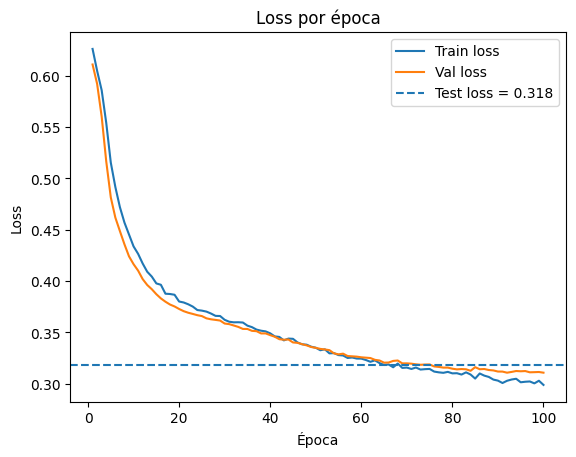

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


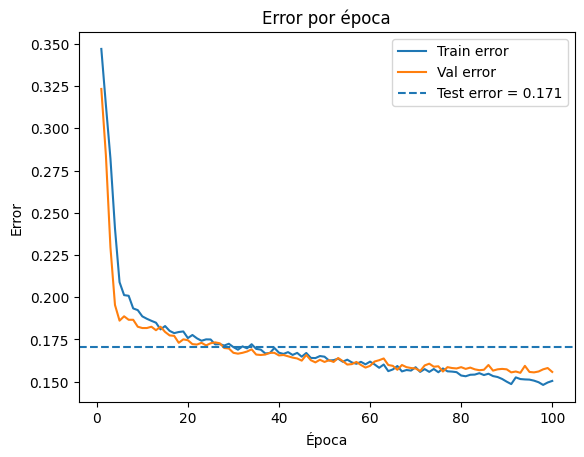

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 1) Pérdida (loss) por época + línea del loss en test
epochs = range(1, len(hist.history['loss']) + 1)
test_loss, test_acc = model.evaluate(X_test_p, y_test, verbose=0)

plt.figure()
plt.plot(epochs, hist.history['loss'], label='Train loss')
plt.plot(epochs, hist.history['val_loss'], label='Val loss')
plt.axhline(test_loss, linestyle='--', label=f'Test loss = {test_loss:.3f}')
plt.xlabel('Época'); plt.ylabel('Loss'); plt.title('Loss por época'); plt.legend(); plt.show()

# 2) Error de clasificación (1 - accuracy) por época + línea del test error
train_err = [1 - acc for acc in hist.history['accuracy']]
val_err   = [1 - acc for acc in hist.history['val_accuracy']]
test_pred = (model.predict(X_test_p)[:,1] >= 0.5).astype(int)
test_err  = 1 - accuracy_score(y_test, test_pred)

plt.figure()
plt.plot(epochs, train_err, label='Train error')
plt.plot(epochs, val_err,   label='Val error')
plt.axhline(test_err, linestyle='--', label=f'Test error = {test_err:.3f}')
plt.xlabel('Época'); plt.ylabel('Error'); plt.title('Error por época'); plt.legend(); plt.show()


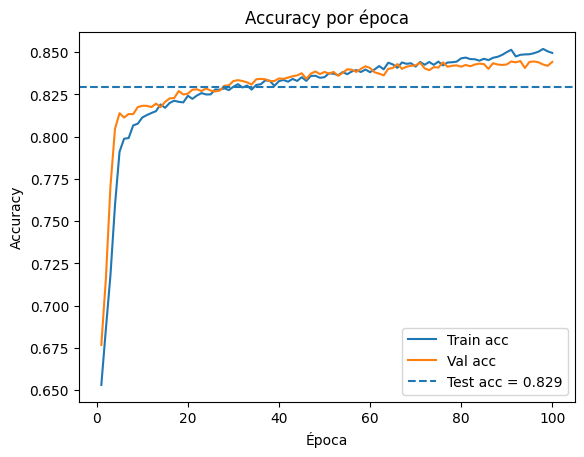

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# Recupera accuracy de Keras con compatibilidad de nombres
train_acc = hist.history.get('accuracy') or hist.history.get('acc')
val_acc   = hist.history.get('val_accuracy') or hist.history.get('val_acc')
epochs    = range(1, len(train_acc) + 1)

# Accuracy de test (línea horizontal)
probs_test = model.predict(X_test_p, verbose=0)
# Soporta tanto softmax(2) como sigmoid(1)
pA_test = probs_test[:, 1] if probs_test.ndim == 2 and probs_test.shape[1] == 2 else probs_test.ravel()
y_pred_test = (pA_test >= 0.5).astype(int)
test_acc = accuracy_score(y_test, y_pred_test)

plt.figure()
plt.plot(epochs, train_acc, label='Train acc')
plt.plot(epochs, val_acc,   label='Val acc')
plt.axhline(test_acc, linestyle='--', label=f'Test acc = {test_acc:.3f}')
plt.xlabel('Época'); plt.ylabel('Accuracy'); plt.title('Accuracy por época')
plt.legend(); plt.show()
